In [1]:
import os
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

from data import loader_train, loader_val, loader_test
from train import train_model, test_model
from models import getModels
from utils import show_img
from trainers import Regression, Classification

In [2]:
# start a new wandb run to track this script
import wandb
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="Test",
    name="MyComputer - Tests",

    # track hyperparameters and run metadata
    config={
        "N_images" : 1,
        "learning_rate": 0.001,
        "dataset": "Expert 1",
        "epochs": 50,
    }
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chermar (chermar-universitat-polit-cnica-de-val-ncia). Use `wandb login --relogin` to force relogin


In [3]:
#train a model
model = getModels()["ResNet18Classification"](num_classes = 5, pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer = Classification(model, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, loader_train, loader_val, trainer, optimizer, device, num_epochs=1, classification = True)
test_model(model, loader_test, trainer, device, classification = True)

c:\Users\34658\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\34658\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: 'NoneType' object is not subscriptable

In [8]:
# Función para entrenar el modelo
import wandb
import torch

def train_model(model, train_loader, val_loader, trainer, optimizer, device, num_epochs=25, classification=True):
    """
    Train the given model
    """
    model.to(device)
    optimizer = trainer.configure_optimizers()
    scheduler = trainer.configure_scheduler(optimizer)

    for epoch in range(num_epochs):


        # Training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            epoch_loss = 0.0
            avg_loss = 0.0


            for iteration, batch in enumerate(loader):
                # Iterar sobre los batches
                inputs, labels = batch
                inputs = inputs.to(device)

                labels = labels.to(device) if classification else labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        res = trainer.validation_step(inputs, labels)
                        loss = res['loss']
                        optimizer.step()
                    else:
                        with torch.no_grad():
                            res = trainer.validation_step(inputs, labels)
                            loss = res['loss']

                # Extraer valores escalares
                loss_value = loss.item()
                accuracy_value = res['accuracy'].item()
                recall_value = res['recall'].item()
                precision_value = res['precision'].item()
                f1_score_value = res['f1_score'].item()

                # Calcular promedios
                epoch_loss += loss_value
                avg_loss = epoch_loss / (iteration + 1)

    
                if phase == 'train':
                    wandb.log({"train_loss": avg_loss, "train_acc": accuracy_value,
                                "train_recall": recall_value, "train_precision": precision_value,
                                "train_f1_score": f1_score_value, "epoch": epoch, "progress" : iteration / len(loader)})
                else:
                    wandb.log({"val_loss": avg_loss, "val_acc": accuracy_value,
                                "val_recall": recall_value, "val_precision": precision_value,
                                "val_f1_score": f1_score_value, "epoch": epoch})

            # Calcular métricas promedio por época
            trainer.restart_epoch()

            # Ajustar el scheduler después de la fase de validación
            if phase == 'val':
                scheduler.step(avg_loss)

def test_model_2(model, test_loader, trainer, device, classification=True):
    """
    Test the given model
    """
    model.eval()
    model.to(device)

    epoch_loss = 0.0
    avg_loss = 0.0

    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        
        labels = labels.to(device) if classification else labels.to(device).float()

        with torch.no_grad():
            res = trainer.validation_step(inputs, labels)
            loss = res['loss']

            # Calcular promedios
            epoch_loss += loss.item()

    avg_loss = epoch_loss / len(test_loader)
    precision_value, recall_value, f1_score_value, accuracy_value = trainer.calculate_metrics_from_confusion_matrix()

    wandb.log({"test_loss": avg_loss, "test_acc": accuracy_value.item(),
                "test_recall": recall_value.item(), "test_precision": precision_value.item(),
                "test_f1_score": f1_score_value.item()})
    
    print(f"Test model {model.__class__.__name__} - Loss: {avg_loss}, Accuracy: {accuracy_value.item()}, Recall: {recall_value.item()}, Precision: {precision_value.item()}, F1 Score: {f1_score_value.item()}")

    trainer.restart_epoch(plot = True)

Test model ResNet18Classification - Loss: 1.1556814496333783, Accuracy: 0.473300963640213, Recall: 0.46273964643478394, Precision: 0.41878026723861694, F1 Score: 0.4396638870239258


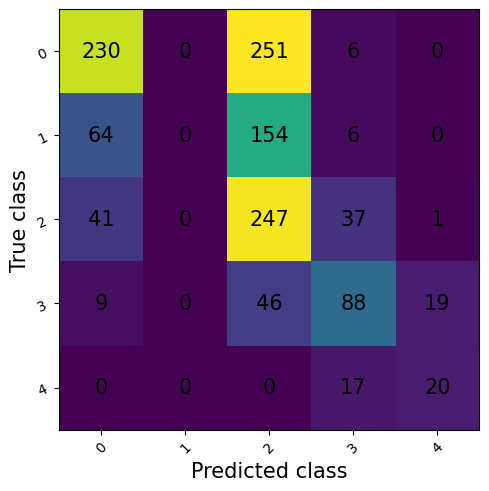

In [9]:
test_model_2(model, loader_test, trainer, device, classification = True)